# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [1]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [2]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [3]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #20000,
    "min_pre_counts" : 100,
    "clip_target" : False, #(-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Omicron_BA.1-2",
    "conditions" : [
        "Delta-3", "Delta-4",
        "Omicron_BA.1-2","Omicron_BA.1-3",
        "Omicron_BA.2-1","Omicron_BA.2-2"
    ]
}

In [4]:
# uncomment to reset or if first time running notebook
# datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

In [5]:
# datasets

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [6]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
# func_score_data_sub = func_score_data.query(
#     f"condition == 'Delta-3'"
# )
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
10,2022-06-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1,Lib-2_2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-2_2022-06-22_thaw-...,library pre_samp...,140643,Omicron_BA.1,Omicron_BA.1-2
11,2022-06-22_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1,Lib-3_2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-3_2022-06-22_thaw-...,library pre_samp...,125127,Omicron_BA.1,Omicron_BA.1-3
12,2022-10-22_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1,Lib-1_2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
13,2022-10-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1,Lib-2_2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2
14,2022-10-22_thaw-2_VSVG_control_1,Lib-1,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1,Lib-1_2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
15,2022-10-22_thaw-2_VSVG_control_1,Lib-2,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1,Lib-2_2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2


In [7]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GATTAGAAAACAACCT,-0.8331,0.0015,9697,1688,1154203,358015,0.5,2,K276R L1198F,2,K278R L1200F,20,Delta,1,Delta-3
1,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAACCGTCACCACCAG,0.1042,0.0010,8201,2734,1154203,358015,0.5,3,T22I R401K E1090D,3,T22I R403K E1092D,20,Delta,1,Delta-3
2,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ACCAAAAGTAGATTCA,0.1985,0.0010,8084,2877,1154203,358015,0.5,2,A1068T,1,A1070T,20,Delta,1,Delta-3
3,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ATCCCACGACATAAAA,-0.3469,0.0015,7226,1762,1154203,358015,0.5,1,D142N,1,D142N,20,Delta,1,Delta-3
4,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GACTAATGACGGGTTC,-0.3512,0.0015,7112,1729,1154203,358015,0.5,0,NaN,0,NaN,20,Delta,1,Delta-3


**Optionally subset the variants**

In [8]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [9]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
#     if "-" in row["aa_substitutions"]:
#         gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/772968 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [10]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 762498 variants, 78831 had fewer than 100 counts before selection, and were filtered out


In [11]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GATTAGAAAACAACCT,-0.8331,0.0015,9697,1688,1154203,358015,0.5,2,K276R L1198F,2,K278R L1200F,20,Delta,1,Delta-3
1,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAACCGTCACCACCAG,0.1042,0.0010,8201,2734,1154203,358015,0.5,3,T22I R401K E1090D,3,T22I R403K E1092D,20,Delta,1,Delta-3
2,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ACCAAAAGTAGATTCA,0.1985,0.0010,8084,2877,1154203,358015,0.5,2,A1068T,1,A1070T,20,Delta,1,Delta-3
3,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ATCCCACGACATAAAA,-0.3469,0.0015,7226,1762,1154203,358015,0.5,1,D142N,1,D142N,20,Delta,1,Delta-3
4,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GACTAATGACGGGTTC,-0.3512,0.0015,7112,1729,1154203,358015,0.5,0,NaN,0,,20,Delta,1,Delta-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759769,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TGGACGAGAAATCCAG,-0.1622,0.0356,100,139,6478978,10063399,0.5,1,E468Q,1,E471Q,56,Omicron_BA.2,2,Omicron_BA.2-2
759770,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTACACAAAACGTGTG,0.5809,0.0296,100,233,6478978,10063399,0.5,1,K1188S,1,K1191S,56,Omicron_BA.2,2,Omicron_BA.2-2
759771,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCATAAAAATTTCAA,1.5701,0.0252,100,463,6478978,10063399,0.5,1,L10I,1,L10I,56,Omicron_BA.2,2,Omicron_BA.2-2
759772,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCCCTGCAATAATTC,1.3412,0.0260,100,395,6478978,10063399,0.5,3,G72C L365I A1219S,3,G75C L368I A1222S,56,Omicron_BA.2,2,Omicron_BA.2-2


**Optionally, scale the counts**

In [12]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [13]:
func_score_df.columns

Index(['library', 'pre_sample', 'post_sample', 'barcode', 'func_score',
       'func_score_var', 'pre_count', 'post_count', 'pre_count_wt',
       'post_count_wt', 'pseudocount', 'n_codon_substitutions',
       'aa_substitutions_sequential', 'n_aa_substitutions', 'aa_substitutions',
       'pre_count_threshold', 'homolog', 'replicate', 'condition'],
      dtype='object')

In [14]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**Optionally, clip the target functional scores**

In [15]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [16]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [17]:
func_score_df

,func_score,aa_substitutions,condition
0,-0.8331,K278R L1200F,Delta-3
1,0.1042,T22I R403K E1092D,Delta-3
2,0.1985,A1070T,Delta-3
3,-0.3469,D142N,Delta-3
4,-0.3512,,Delta-3
...,...,...,...
759769,-0.1622,E471Q,Omicron_BA.2-2
759770,0.5809,K1191S,Omicron_BA.2-2
759771,1.5701,L10I,Omicron_BA.2-2
759772,1.3412,G75C L368I A1222S,Omicron_BA.2-2


In [18]:
import polyclonal
from functools import partial

In [19]:
rep1_name_map = {
    "Delta-3":"Delta", 
    "Omicron_BA.1-2":"Omicron_BA1", 
    "Omicron_BA.2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA.1-3":"Omicron_BA1", 
    "Omicron_BA.2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

## `MultiDmsData`

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

In [20]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [21]:
datasets = pd.DataFrame()
for rep in [fs_rep1, fs_rep2]:
    start = time.time()
    data = multidms.MultiDmsData(
        rep,
        alphabet= multidms.AAS_WITHSTOP_WITHGAP,
        condition_colors = sns.color_palette("Paired"),
        reference="Omicron_BA1",
        assert_site_integrity = False,
        verbose=True
    )
    end = time.time()
    print(f"Finished, time: {round(end-start)}")
    data_row = pd.Series(prep_params).to_frame().T
    data_row['data'] = data
    datasets = pd.concat([datasets, data_row], ignore_index=True)
    
datasets

inferring site map for Delta
inferring site map for Omicron_BA1
inferring site map for Omicron_BA2
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 45
inferring site map for Delta
inferring site map for Omicron_BA1
inferring site map for Omicron_BA2
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 39


,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,False,False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f5f5e...
1,False,100,0.1,False,False,False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f5f3d...


**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [36]:
# un-comment to re-initialize results
models = defaultdict(list)

In [37]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,False,False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f5f5e...
1,False,100,0.1,False,False,False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f5f3d...


In [38]:
# models

**Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.**

In [39]:
import multidms.model as model
for dataset in datasets.index:
    for ge_func in [model.sigmoidal_global_epistasis]:
        for output_act in [model.softplus_activation]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    epistatic_model=ge_func,
                    output_activation=output_act,
                    n_percep_units=10
            )
            
            start = time.time()
            imodel.fit(lasso_shift=1e-5, maxiter=10000, tol=1e-6)
            end = time.time()
            print(f"done. fitting time = {round(end - start)} seconds")
            
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

done. fitting time = 123 seconds
done. fitting time = 121 seconds


,model,dataset
0,<multidms.model.MultiDmsModel object at 0x7f5f...,0
1,<multidms.model.MultiDmsModel object at 0x7f5f...,1


### Visualization

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

In [40]:
import matplotlib.colors as colors

palette = [
    '#F97306',#, '#FFA500',
    '#BFBFBF',#,'#404040',
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [41]:
moi1 = models_df.loc[0, "model"]
moi2 = models_df.loc[1, "model"]
import multidms.plot

In [42]:
# chart = multidms.plot.mut_shift_plot({"rep1":moi1, "rep2":moi2}, include_beta=True)
# chart.save("replicates-w-beta.html")


In [43]:
# chart = multidms.plot.mut_shift_plot({"rep1":moi1, "rep2":moi2}, include_beta=False)
# # chart.save("replicates-wo-beta.html")
# chart

In [44]:
nis1 = moi1.data.non_identical_sites
nis2 = moi2.data.non_identical_sites

In [45]:
df = multidms.plot.mut_shift_plot({"rep1":moi1, "rep2":moi2}, include_beta=True, times_seen_threshold=5)
df = df[["wildtype", "site", "mutant"] + sorted(list(set(df.columns)-set(["wildtype", "site", "mutant"])))]
df_site = df.groupby("site").aggregate(onp.sum)
for condition in ["Delta", "Omicron_BA2"]:
    df_site.loc[:, f"is_{condition}_nis"] = [                                                                     
        True if s in nis1[condition].index else False                                                      
        for s in df_site.index             
    ]

/tmp/ipykernel_22673/4201978614.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_site = df.groupby("site").aggregate(onp.sum)


In [46]:
df

,wildtype,site,mutant,rep1_S_Delta,rep1_S_Omicron_BA2,rep1_β,rep2_S_Delta,rep2_S_Omicron_BA2,rep2_β,value_S_Delta,value_S_Omicron_BA2,value_β
mutation,,,,,,,,,,,,
M1I,M,1,I,0.026858,0.012159,-4.749413,-0.169321,0.062931,-4.944319,-0.071232,0.037545,-4.846866
F2L,F,2,L,-0.253589,-0.288428,0.101572,-0.097632,0.001049,0.113712,-0.175610,-0.143689,0.107642
V3F,V,3,F,-0.189197,0.041647,-0.365086,0.000852,-0.003693,-0.224838,-0.094172,0.018977,-0.294962
V3G,V,3,G,0.028638,-0.000228,-0.002759,0.044793,-0.106406,0.050990,0.036716,-0.053317,0.024115
V3I,V,3,I,0.012601,0.119669,-0.111967,-0.019897,0.193017,-0.235275,-0.003648,0.156343,-0.173621
...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.384607,-0.116148,-0.134231,-0.558303,-0.064281,-0.161383,-0.471455,-0.090215,-0.147807
S1252V,S,1252,V,-0.164426,-0.005293,0.197762,1.151869,-0.166830,0.268040,0.493722,-0.086062,0.232901
S1252W,S,1252,W,-0.124558,0.073530,0.047889,1.620900,-0.024933,0.317154,0.748171,0.024299,0.182521


In [47]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

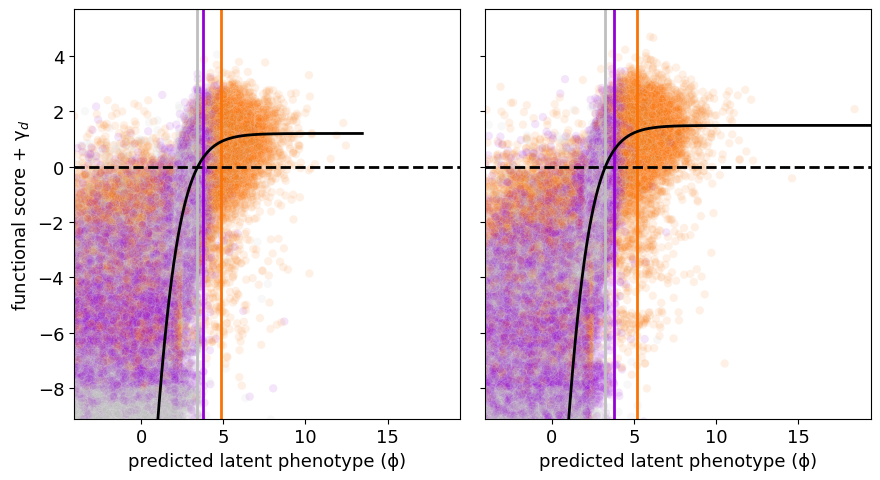

In [48]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,2, figsize=[9,5], sharex=True, sharey=True)
moi1.plot_epistasis(alpha=0.1, ax=ax[0], show=False, legend=False)
moi2.plot_epistasis(alpha=0.1, ax=ax[1], show=False, legend=False)
fig.savefig(f"epistasis-1e.png")
plt.show()

NameError: name 'pearsonr' is not defined

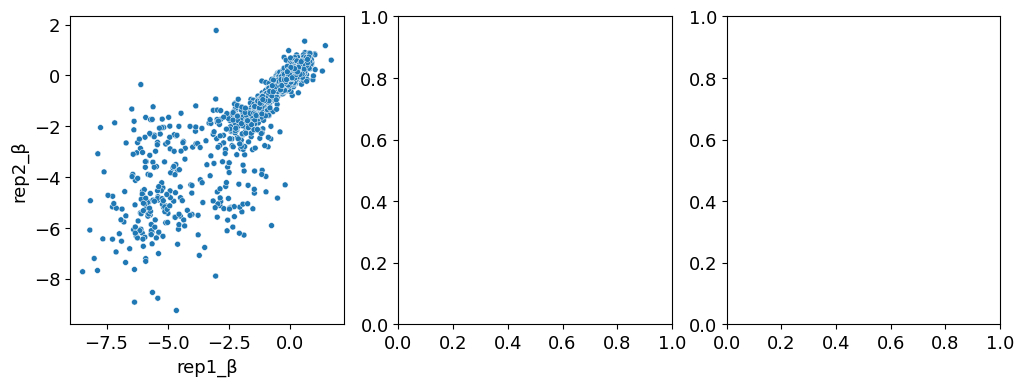

In [49]:
plt.rcParams.update({'font.size': 13})
import math
fig, ax = plt.subplots(1,3,figsize=[12,4])

# i=0
for j, param in enumerate(["β","S_Delta", "S_Omicron_BA2"]):
#     ax = ax[j]
    sns.scatterplot(                                       
        data=df,
        x=f"rep1_{param}",
        y=f"rep2_{param}",                        
        size=2,               
#         color=cc[condition],                                                    
        ax=ax[j],                                                             
        legend=False                       
    )
#     ax[i, j].get_xaxis().set_visible(False)
#     ax[i, j].get_yaxis().set_visible(False)

    x = df[f"rep1_{param}"]
    y = df[f"rep2_{param}"]
    r = pearsonr(x, y)[0]

    ax[j].annotate(
        f"$r = {r:.2f}$", (0.1, 0.9),
        xycoords="axes fraction", fontsize=15, color="black"
    )
    ax[j].set_title(param)
    ax[j].set_xlabel("replicate 1")
    ax[j].set_ylabel("replicate 2")
plt.tight_layout()
fig.savefig(f"rep-corr-mut.png")
plt.show()
    

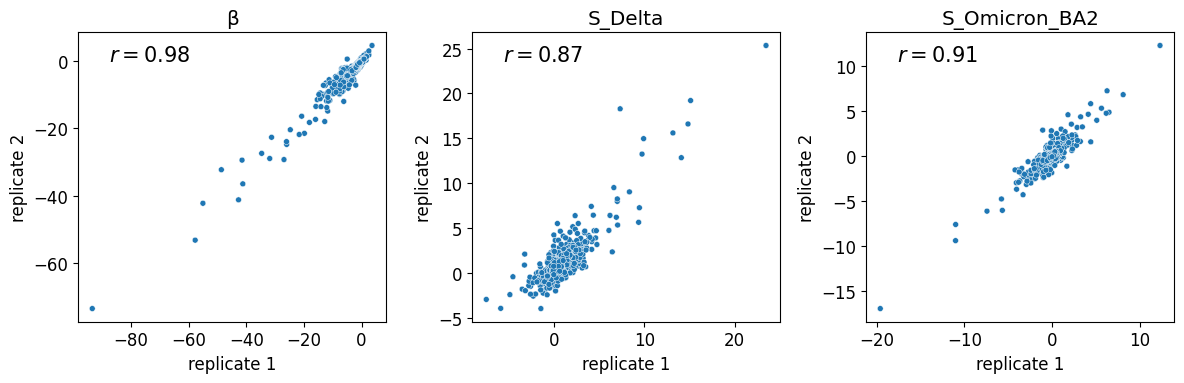

In [399]:
plt.rcParams.update({'font.size': 12})
import math
fig, ax = plt.subplots(1,3,figsize=[12,4])

# i=0
for j, param in enumerate(["β","S_Delta", "S_Omicron_BA2"]):
#     ax = ax[j]
    sns.scatterplot(                                       
        data=df_site,
        x=f"rep1_{param}",
        y=f"rep2_{param}",                        
        size=2,               
#         color=cc[condition],                                                    
        ax=ax[j],                                                             
        legend=False                       
    )
#     ax[i, j].get_xaxis().set_visible(False)
#     ax[i, j].get_yaxis().set_visible(False)

    x = df_site[f"rep1_{param}"]
    y = df_site[f"rep2_{param}"]
    r = pearsonr(x, y)[0]

    ax[j].annotate(
        f"$r = {r:.2f}$", (0.1, 0.9),
        xycoords="axes fraction", fontsize=15, color="black"
    )
    ax[j].set_title(param)
    ax[j].set_xlabel("replicate 1")
    ax[j].set_ylabel("replicate 2")
    
plt.tight_layout()
fig.savefig(f"rep-corr-site.png")

plt.show()
    

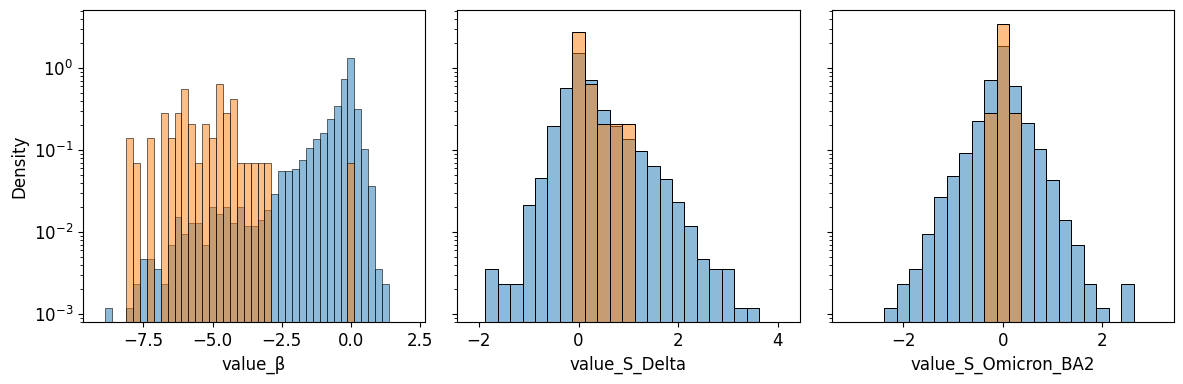

In [369]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1,3,figsize=[12,4], sharey=True)
for j, param in enumerate(["value_β","value_S_Delta", "value_S_Omicron_BA2"]):
#     ax=ax[j]

#     fig, ax = plt.subplots(figsize=[3, 3])
    data = df[df["mutant"] != "*"]
    bin_width = 0.25
    min_val = math.floor(data[param].min()) - 0.25 / 2
    max_val = math.ceil(data[param].max())
    sns.histplot(
        x=param,
        data=data,
        ax=ax[j],
        stat="density",
        label="muts to amino acids",
        binwidth=bin_width,
        binrange=(min_val, max_val),
        alpha=0.5
    )

    # Plot data for mutations leading to stop codons
    data = df[df["mutant"] == "*"]
    if len(data) > 0:
        sns.histplot(
            x=param,
            data=data,
            ax=ax[j],
            stat="density",
            label="muts to stop codons",
            binwidth=bin_width,
            binrange=(min_val, max_val),
            alpha=0.5
        )

    ax[j].set(xlabel=param)
#     ax[i].set(title=group)
    ax[j].set_yscale("log")
#     ax.legend()
plt.tight_layout()

fig.savefig(f"avg-hist-param.png")

# plt.tight_layout()
plt.show()

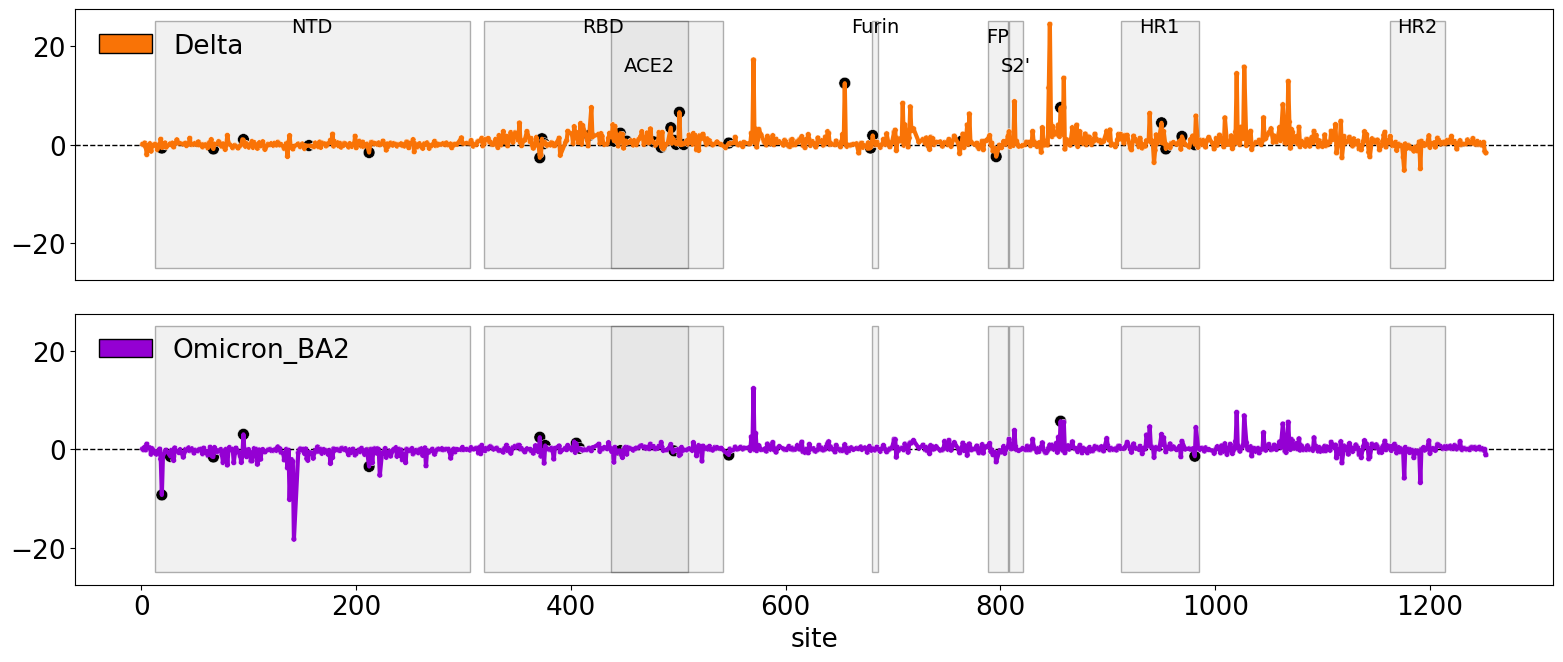

In [386]:
from scipy.stats import pearsonr
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

plt.rcParams.update({'font.size': 19})

fig = plt.figure(constrained_layout=True, figsize=(16,7))
axd = fig.subplot_mosaic(
    """
    b
    d
    """,
    empty_sentinel="X",
    gridspec_kw={ 
    }
)

protein_regions = {
    "NTD" :  [13, 305],                                                 
    "RBD" : [319, 541],
    "ACE2" : [437, 508],
    "Furin" : [680, 685],
    "FP" : [788, 806],
    "S2'"  : [808, 820],
    "HR1" : [912, 984],
    "HR2" : [1163, 1213]
}

facet_groups = {
    ("b", "g") : "Delta", #(f"{r}_S_Delta" for r in ["rep1", "rep2", "avg"]),
    ("d", "h") : "Omicron_BA2" #(f"{r}_S_Delta" for r in ["rep1", "rep2", "avg"])
}

for axi, condition in facet_groups.items():

    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        rect_v = patches.Rectangle(
                (start, -25),
                width=width,
                height=50,
                clip_on=False,
                linewidth=1,
                edgecolor='black',
                facecolor='lightgrey',
                alpha=0.3
        )
        axd[axi[0]].add_patch(rect_v)


    axd[axi[0]].axhline(0, color="k", ls="--", lw=1)


    sns.lineplot(                                       
        data=df_site,                                
        x="site",                     
        y=f"value_S_{condition}",                              
        lw=3,                             
        color=cc[condition],                                                    
        ax=axd[axi[0]],                                                             
        legend=True                       
    )

    color = [                                                                     
        cc[condition]                            
        if not s in nis1[condition].index
        else (0.0, 0.0, 0.0)                                                      
        for s in df_site.index             
    ]                                                                              
    size = [                                
        10 if not s in nis1[condition].index else 15
        for s in df_site.index 
    ] 
    sns.scatterplot(                                       
        data=df_site,                                
        x="site",                     
        y=f"value_S_{condition}",                              
        size=size,                             
        color=color,                                                    
        ax=axd[axi[0]],                                                             
#         legend=False                        
    )


#         for r in ["rep1", "rep2"]:                   

#             sns.lineplot(                                              
#                 data=df_site,                       
#                 x="site",                                                               
#                 y=f"{r}_S_{condition}",
#                 lw=1,
#                 alpha=0.5,
#                 color="grey",                
#                 ax=axd[axi[0]],                                
#                 legend=False                                                    
#             )
    axd[axi[0]].set_ylabel("")

#     sns.scatterplot(                                       
#         data=df_site,
#         x=f"rep1_S_{condition}",
#         y=f"rep2_S_{condition}",                        
#         size=size,               
#         color=cc[condition],                                                    
#         ax=axd[axi[1]],                                                             
#         legend=False                       
#     )
#     axd[axi[1]].get_xaxis().set_visible(False)
#     axd[axi[1]].get_yaxis().set_visible(False)

#     x = df_site[f"rep1_S_{condition}"]
#     y = df_site[f"rep2_S_{condition}"]
#     r = pearsonr(x, y)[0]

#     axd[axi[1]].annotate(
#         f"$r = {r:.2f}$", (0.1, 0.9),
#         xycoords="axes fraction", fontsize=15, color="black"
#     )

for pr, data in protein_regions.items():

    start = data[0]
    end = data[1] + 1
    width = end - start
    middle = start + (width//2)

    anno = f"{pr}"
    ycoord = 24
    if pr in ["ACE2", "S2'"]:
        ycoord = 16
    if pr in ["FP"]:
        ycoord = 22

    axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=14, rotation=0)
    


axd["b"].get_xaxis().set_visible(False)
# axd["b"].legend()
# axd["d"].legend()

# axd["g"].axis('off')

legend_elements = [
    patches.Patch(
         facecolor=cc["Omicron_BA2"], 
         edgecolor="black", 
         label="Omicron_BA2"
    )
]
axd["d"].legend(
        handles=legend_elements, 
        loc="upper left",
        frameon=False
)
legend_elements = [
    patches.Patch(
         facecolor=cc["Delta"], 
         edgecolor="black", 
         label="Delta"
    )
]
axd["b"].legend(
        handles=legend_elements, 
        loc="upper left",
        frameon=False
)


plt.tight_layout()
fig.savefig(f"site-shift.png")

plt.show()
#     fig.savefig("")